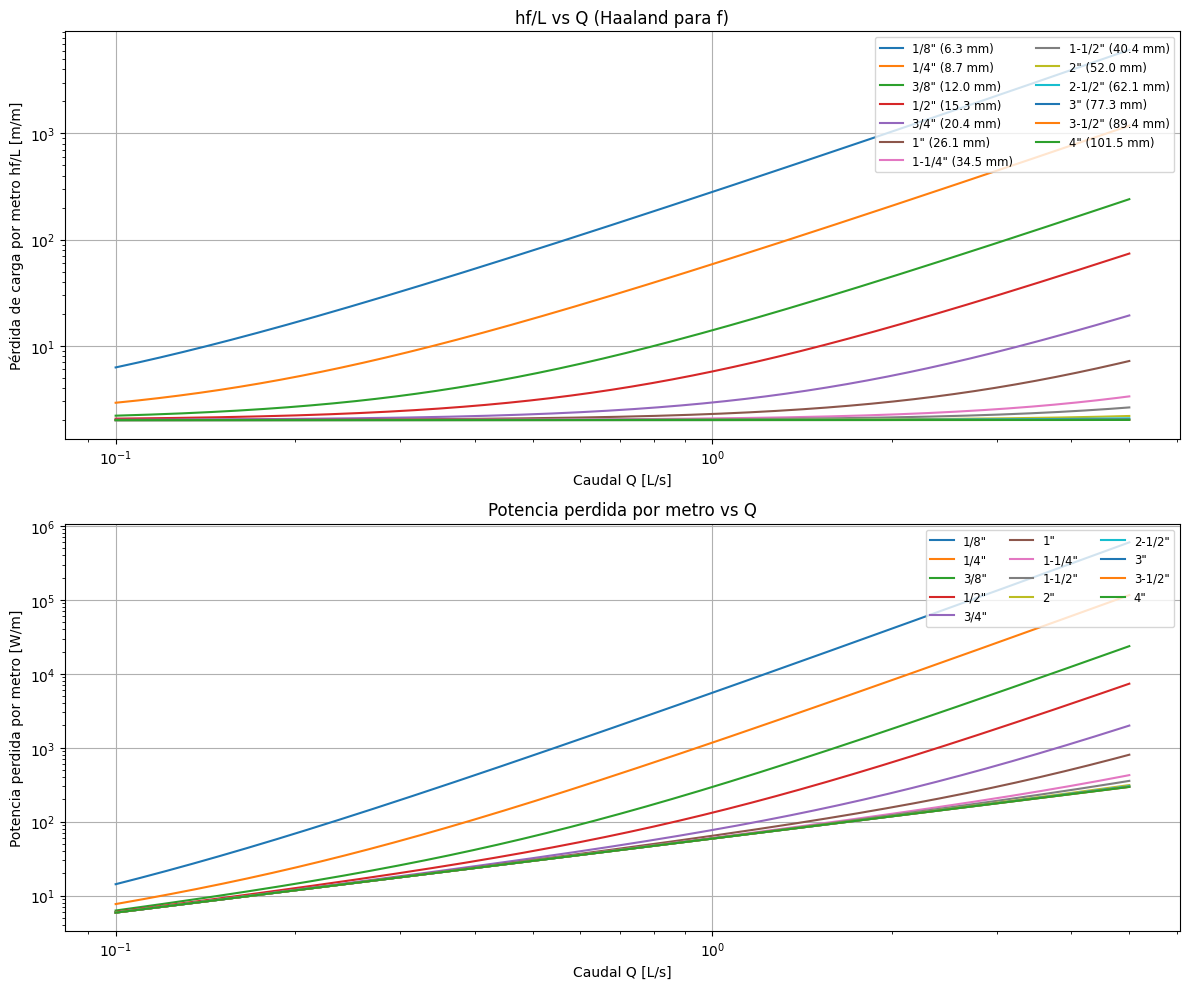

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "Nom. Pipe Size (in)": [
        "1/8", "1/4", "3/8", "1/2", "3/4", "1", "1-1/4", "1-1/2", "2", "2-1/2", "3", "3-1/2", "4"
    ],
    "Average I.D.": [
        0.249, 0.344, 0.473, 0.602, 0.804, 1.029, 1.360, 1.590, 2.047, 2.445, 3.042, 3.521, 3.998
    ]  # pulgadas
}

df = pd.DataFrame(data)

# --- Constantes y conversiones ---
inch_to_m = 0.0254
df["D_m"] = df["Average I.D."] * inch_to_m         # diámetro interno [m]
rho = 1000.0     # densidad agua [kg/m3]
mu = 1.002e-3    # viscosidad dinámica agua ~20°C [Pa·s]
g = 9.81         # gravedad [m/s2]
eps = 1.5e-6     # rugosidad absoluta PVC [m] (valor típico: 0.0015 mm)

# --- Rango de caudales ---
# desde 0.001 L/s hasta 20 L/s => 1e-6 a 0.02 m3/s 
Q_0=0.1 # L/s
Q_1=5 # L/s
Q=np.logspace(np.log10(Q_0*1e-3), np.log10(Q_1*1e-3), 500) # alternativo logarítmico 
# Función Haaland para factor de fricción de Darcy
def darcy_f_haaland(Re, D, eps):
    # para Re < 2300 usar régimen laminar f = 64/Re
    f = np.zeros_like(Re)
    laminar_idx = Re <= 2300
    turbulent_idx = ~laminar_idx
    # laminar
    if np.any(laminar_idx):
        f[laminar_idx] = 64.0 / Re[laminar_idx]
    # turbulento: Haaland
    if np.any(turbulent_idx):
        Re_t = Re[turbulent_idx]
        term = (eps / (3.7 * D))**1.11 + 6.9 / Re_t
        inv_sqrt_f = -1.8 * np.log10(term)
        f[turbulent_idx] = (1.0 / inv_sqrt_f)**2
    return f

# Prealocar matrices para resultados
hf_per_m_all = np.zeros((len(df), len(Q)))   # hf/L [m/m]
P_loss_per_m_all = np.zeros_like(hf_per_m_all) # W/m


for i, row in df.iterrows():
    D = row["D_m"]
    A = np.pi * D**2 / 4.0
    v = Q / A                               # velocidad [m/s]
    Re = rho * v * D / mu                   # Reynolds
    f = darcy_f_haaland(Re, D, eps)         # factor de fricción de Darcy
    hf_L = 2+2*f* (v**2) / (2.0 * g * D)       # pérdida por metro [m/m]
    P_loss_L = rho * g * Q * (2*hf_L+2)           # potencia perdida por metro [W/m]
    hf_per_m_all[i, :] = hf_L
    P_loss_per_m_all[i, :] = P_loss_L

# --- Graficar ---
plt.figure(figsize=(12, 10))

# subplot 1: hf/L vs Q (L/s)
plt.subplot(2, 1, 1)
for i, row in df.iterrows():
    plt.loglog(Q*1e3, hf_per_m_all[i, :], label=f'{row["Nom. Pipe Size (in)"]}" ({round(row["D_m"]*1000,1)} mm)')
plt.xlabel("Caudal Q [L/s]")
plt.ylabel("Pérdida de carga por metro hf/L [m/m]")
plt.title("hf/L vs Q (Haaland para f)")
plt.grid(True)
plt.legend(ncol=2, fontsize='small', loc='upper right')

# subplot 2: Potencia perdida por metro vs Q
plt.subplot(2, 1, 2)
for i, row in df.iterrows():
    plt.loglog(Q*1e3, P_loss_per_m_all[i, :], label=f'{row["Nom. Pipe Size (in)"]}"')
plt.xlabel("Caudal Q [L/s]")
plt.ylabel("Potencia perdida por metro [W/m]")
plt.title("Potencia perdida por metro vs Q")
plt.grid(True)
plt.legend(ncol=3, fontsize='small', loc='upper right')

plt.tight_layout()
plt.show()

# --- (Opcional) Guardar resultados en un DataFrame "largo" para exportar ---
# construimos tabla con Q y por cada tubo la potencia perdida por m
out = {"Q_m3s": np.repeat(Q, len(df))}
names = []
vals = []
for i, row in df.iterrows():
    names.append(row["Nom. Pipe Size (in)"])
    vals.append(P_loss_per_m_all[i,:])
vals = np.array(vals)  # shape (n_pipes, n_Q)
# añadir columnas por tubería
out_df = pd.DataFrame({"Q_m3s": Q})
for i, name in enumerate(names):
    out_df[f"P_loss_W_per_m_{name}\""] = vals[i, :]
# export opcional
# out_df.to_csv("potencia_perdida_por_metro_schedule40.csv", index=False)


Diámetro óptimo (m):  1-1/2
Costo total (COP):  55700.0
Potencia de entrada requerida (W):  228.82415916514432
   Nom. Pipe Size (in)  Average I.D.       D_m            Ct         P_in_W
0                  1/8         0.249  0.006325  2.889869e+07  210025.818420
1                  1/4         0.344  0.008738  5.664143e+06   41132.361561
2                  3/8         0.473  0.012014  1.184721e+06    8558.884565
3                  1/2         0.602  0.015291  3.871276e+05    2747.195177
4                  3/4         0.804  0.020422  1.255296e+05     823.364494
5                    1         1.029  0.026137  6.965388e+04     392.301069
6                1-1/4         1.360  0.034544  5.573005e+04     254.428032
7                1-1/2         1.590  0.040386  5.571273e+04     228.824159
8                    2         2.047  0.051994  6.047100e+04     212.786675
9                2-1/2         2.445  0.062103  6.600192e+04     208.900843
10                   3         3.042  0.077267  7.484

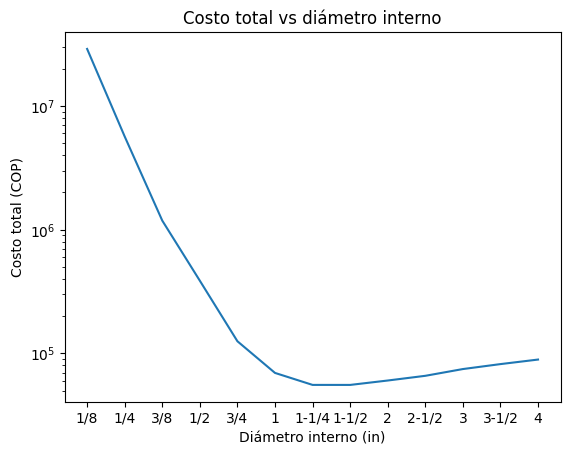

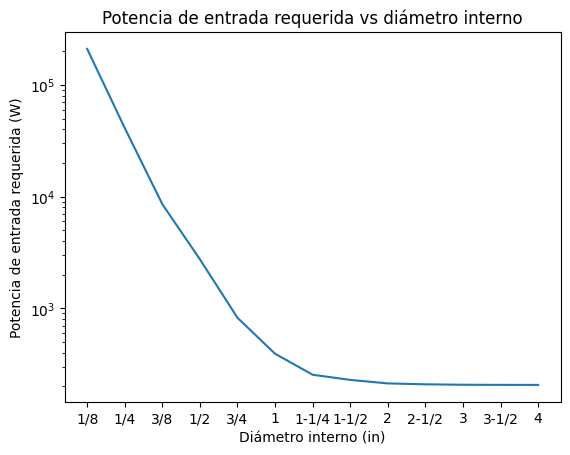

In [80]:
k_t=3e5
k_b=30000/239
k_e=880
L=2
Ct=np.zeros(len(df))
P_in=np.zeros(len(df))
N=5/365
T_h=1
Q=3.5e-3  # caudal fijo de 5 L/s
for i in range(len(df)):
    D = df["D_m"].iloc[i]
    A = np.pi * D**2 / 4.0
    v = Q / A                               # velocidad [m/s]
    Re = rho * v * D / mu                   # Reynolds
    f = darcy_f_haaland(Re, D, eps)         # factor de fricción de Darcy
    hf_L = 2+2*f* (v**2) / (2.0 * g * D)       # pérdida [m]
    P_loss_L = rho * g * Q * (2*hf_L+2)           # potencia perdida [W]
    n_b=1
    P_in[i]=P_loss_L*n_b
    Ct[i]=k_t*D*L/N+P_in[i]*(k_b/N+k_e*T_h)
    Ct[i]=Ct[i]*N
    #Ct[i]=k_t*D*L+P_in[i]*k_b
plt.figure()
plt.semilogy(df["Nom. Pipe Size (in)"],Ct)
plt.xlabel("Diámetro interno (in)")
plt.ylabel("Costo total (COP)")
plt.title("Costo total vs diámetro interno")

plt.figure()
plt.semilogy(df["Nom. Pipe Size (in)"],P_in)
plt.xlabel("Diámetro interno (in)")  
plt.ylabel("Potencia de entrada requerida (W)")
plt.title("Potencia de entrada requerida vs diámetro interno")

print("Diámetro óptimo (m): ", df["Nom. Pipe Size (in)"].iloc[np.argmin(Ct)])
print("Costo total (COP): ", np.min(Ct.round(-2)))
print("Potencia de entrada requerida (W): ", P_in[np.argmin(Ct)])

df["Ct"] = Ct
df["P_in_W"] = P_in
print(df)